In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt # For accuracy plot
from tqdm.auto import tqdm # For progress bars
from data_loader import get_cifar100_loaders
from evaluation_utils import (evaluate_model, plot_confusion_matrix,
                              visualize_misclassified, get_cifar100_class_names)



In [3]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=100, input_size=32):
        super(CustomCNN, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 32x32 -> 16x16

        # Block 2
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 16x16 -> 8x8

        # Block 3
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 8x8 -> 4x4 (if input_size=32)

        # Calculate input features for FC layer based on input_size
        fc_input_features = 256 * (input_size // 8) * (input_size // 8)

        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(fc_input_features, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(F.relu(self.bn4(self.conv4(x))))
        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool3(F.relu(self.bn6(self.conv6(x))))

        # Fully Connected
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
def train_model(model, train_loader, test_loader, num_epochs, learning_rate, device, model_name="1_CustomCNN"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    model.to(device)

    best_accuracy = 0.0
    model_save_path = f'{model_name}_cifar100_best.pth'

    # Store epoch-wise accuracy for plotting
    train_acc_history = []
    test_acc_history = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop with progress bar
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for i, (inputs, labels) in enumerate(train_iterator):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            train_iterator.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc_train = 100.0 * correct_train / total_train
        train_acc_history.append(epoch_acc_train)

        # Validation loop with progress bar
        model.eval()
        correct_test = 0
        total_test = 0
        test_iterator = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for inputs, labels in test_iterator:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        epoch_acc_test = 100.0 * correct_test / total_test
        test_acc_history.append(epoch_acc_test)
        end_time = time.time()
        epoch_duration = end_time - start_time

        current_lr = optimizer.param_groups[0]['lr']

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc_train:.2f}% | '
              f'Test Acc: {epoch_acc_test:.2f}% | LR: {current_lr:.6f} | '
              f'Duration: {epoch_duration:.2f}s')

        # Save best model
        if epoch_acc_test > best_accuracy:
            best_accuracy = epoch_acc_test
            try:
                torch.save(model.state_dict(), model_save_path)
                print(f'>>> Best model saved to {model_save_path} with Test Accuracy: {best_accuracy:.2f}%')
            except Exception as e:
                 print(f"Lỗi khi lưu model: {e}")

    print('Finished Training')
    print(f'Best Validation Accuracy achieved during training: {best_accuracy:.2f}%')

    # Load the best model state for final evaluation
    print(f"Loading best model state from {model_save_path} for final evaluation...")
    try:
        model.load_state_dict(torch.load(model_save_path))
    except Exception as e:
        print(f"Could not load best model state: {e}. Evaluating with the final model state.")

    return model, train_acc_history, test_acc_history

Sử dụng thiết bị: cpu
Files already downloaded and verified
Đang tải dữ liệu CIFAR-100 (Input size: 32x32)...
Files already downloaded and verified
Files already downloaded and verified
Đã tải xong CIFAR-100.
Số lượng ảnh Train: 50000
Số lượng ảnh Test: 10000
Kích thước ảnh: 32x32
Sử dụng Data Augmentation: True
Khởi tạo Custom CNN model...
Bắt đầu huấn luyện Custom CNN...


Epoch 1/5 [Train]:   0%|          | 0/391 [00:17<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/79 [00:11<?, ?it/s]

Epoch 1/5 | Train Loss: 4.4932 | Train Acc: 2.68% | Test Acc: 5.66% | LR: 0.001000 | Duration: 525.53s
>>> Best model saved to custom_cnn_cifar100_best.pth with Test Accuracy: 5.66%


Epoch 2/5 [Train]:   0%|          | 0/391 [00:16<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/79 [00:12<?, ?it/s]

Epoch 2/5 | Train Loss: 4.3395 | Train Acc: 3.90% | Test Acc: 7.06% | LR: 0.001000 | Duration: 685.13s
>>> Best model saved to custom_cnn_cifar100_best.pth with Test Accuracy: 7.06%


Epoch 3/5 [Train]:   0%|          | 0/391 [00:16<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/79 [00:12<?, ?it/s]

Epoch 3/5 | Train Loss: 4.2424 | Train Acc: 4.60% | Test Acc: 8.84% | LR: 0.001000 | Duration: 537.37s
>>> Best model saved to custom_cnn_cifar100_best.pth with Test Accuracy: 8.84%


Epoch 4/5 [Train]:   0%|          | 0/391 [00:17<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/79 [00:11<?, ?it/s]

Epoch 4/5 | Train Loss: 4.1678 | Train Acc: 5.51% | Test Acc: 12.19% | LR: 0.001000 | Duration: 517.74s
>>> Best model saved to custom_cnn_cifar100_best.pth with Test Accuracy: 12.19%


Epoch 5/5 [Train]:   0%|          | 0/391 [00:17<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/79 [00:12<?, ?it/s]

Epoch 5/5 | Train Loss: 4.0771 | Train Acc: 6.56% | Test Acc: 13.09% | LR: 0.001000 | Duration: 566.60s
>>> Best model saved to custom_cnn_cifar100_best.pth with Test Accuracy: 13.09%
Finished Training
Best Validation Accuracy achieved during training: 13.09%
Loading best model state from custom_cnn_cifar100_best.pth for final evaluation...

--- Performing Final Evaluation on Test Set ---
Evaluating on test set...


  0%|          | 0/79 [00:11<?, ?it/s]


Classification Report:
               precision    recall  f1-score   support

        apple       0.00      0.00      0.00       100
aquarium_fish       0.23      0.05      0.08       100
         baby       0.00      0.00      0.00       100
         bear       0.00      0.00      0.00       100
       beaver       0.00      0.00      0.00       100
          bed       0.20      0.02      0.04       100
          bee       0.12      0.16      0.13       100
       beetle       0.00      0.00      0.00       100
      bicycle       0.16      0.17      0.17       100
       bottle       0.22      0.24      0.23       100
         bowl       0.25      0.01      0.02       100
          boy       0.00      0.00      0.00       100
       bridge       0.19      0.12      0.15       100
          bus       0.08      0.04      0.05       100
    butterfly       0.00      0.00      0.00       100
        camel       0.00      0.00      0.00       100
          can       0.00      0.00      

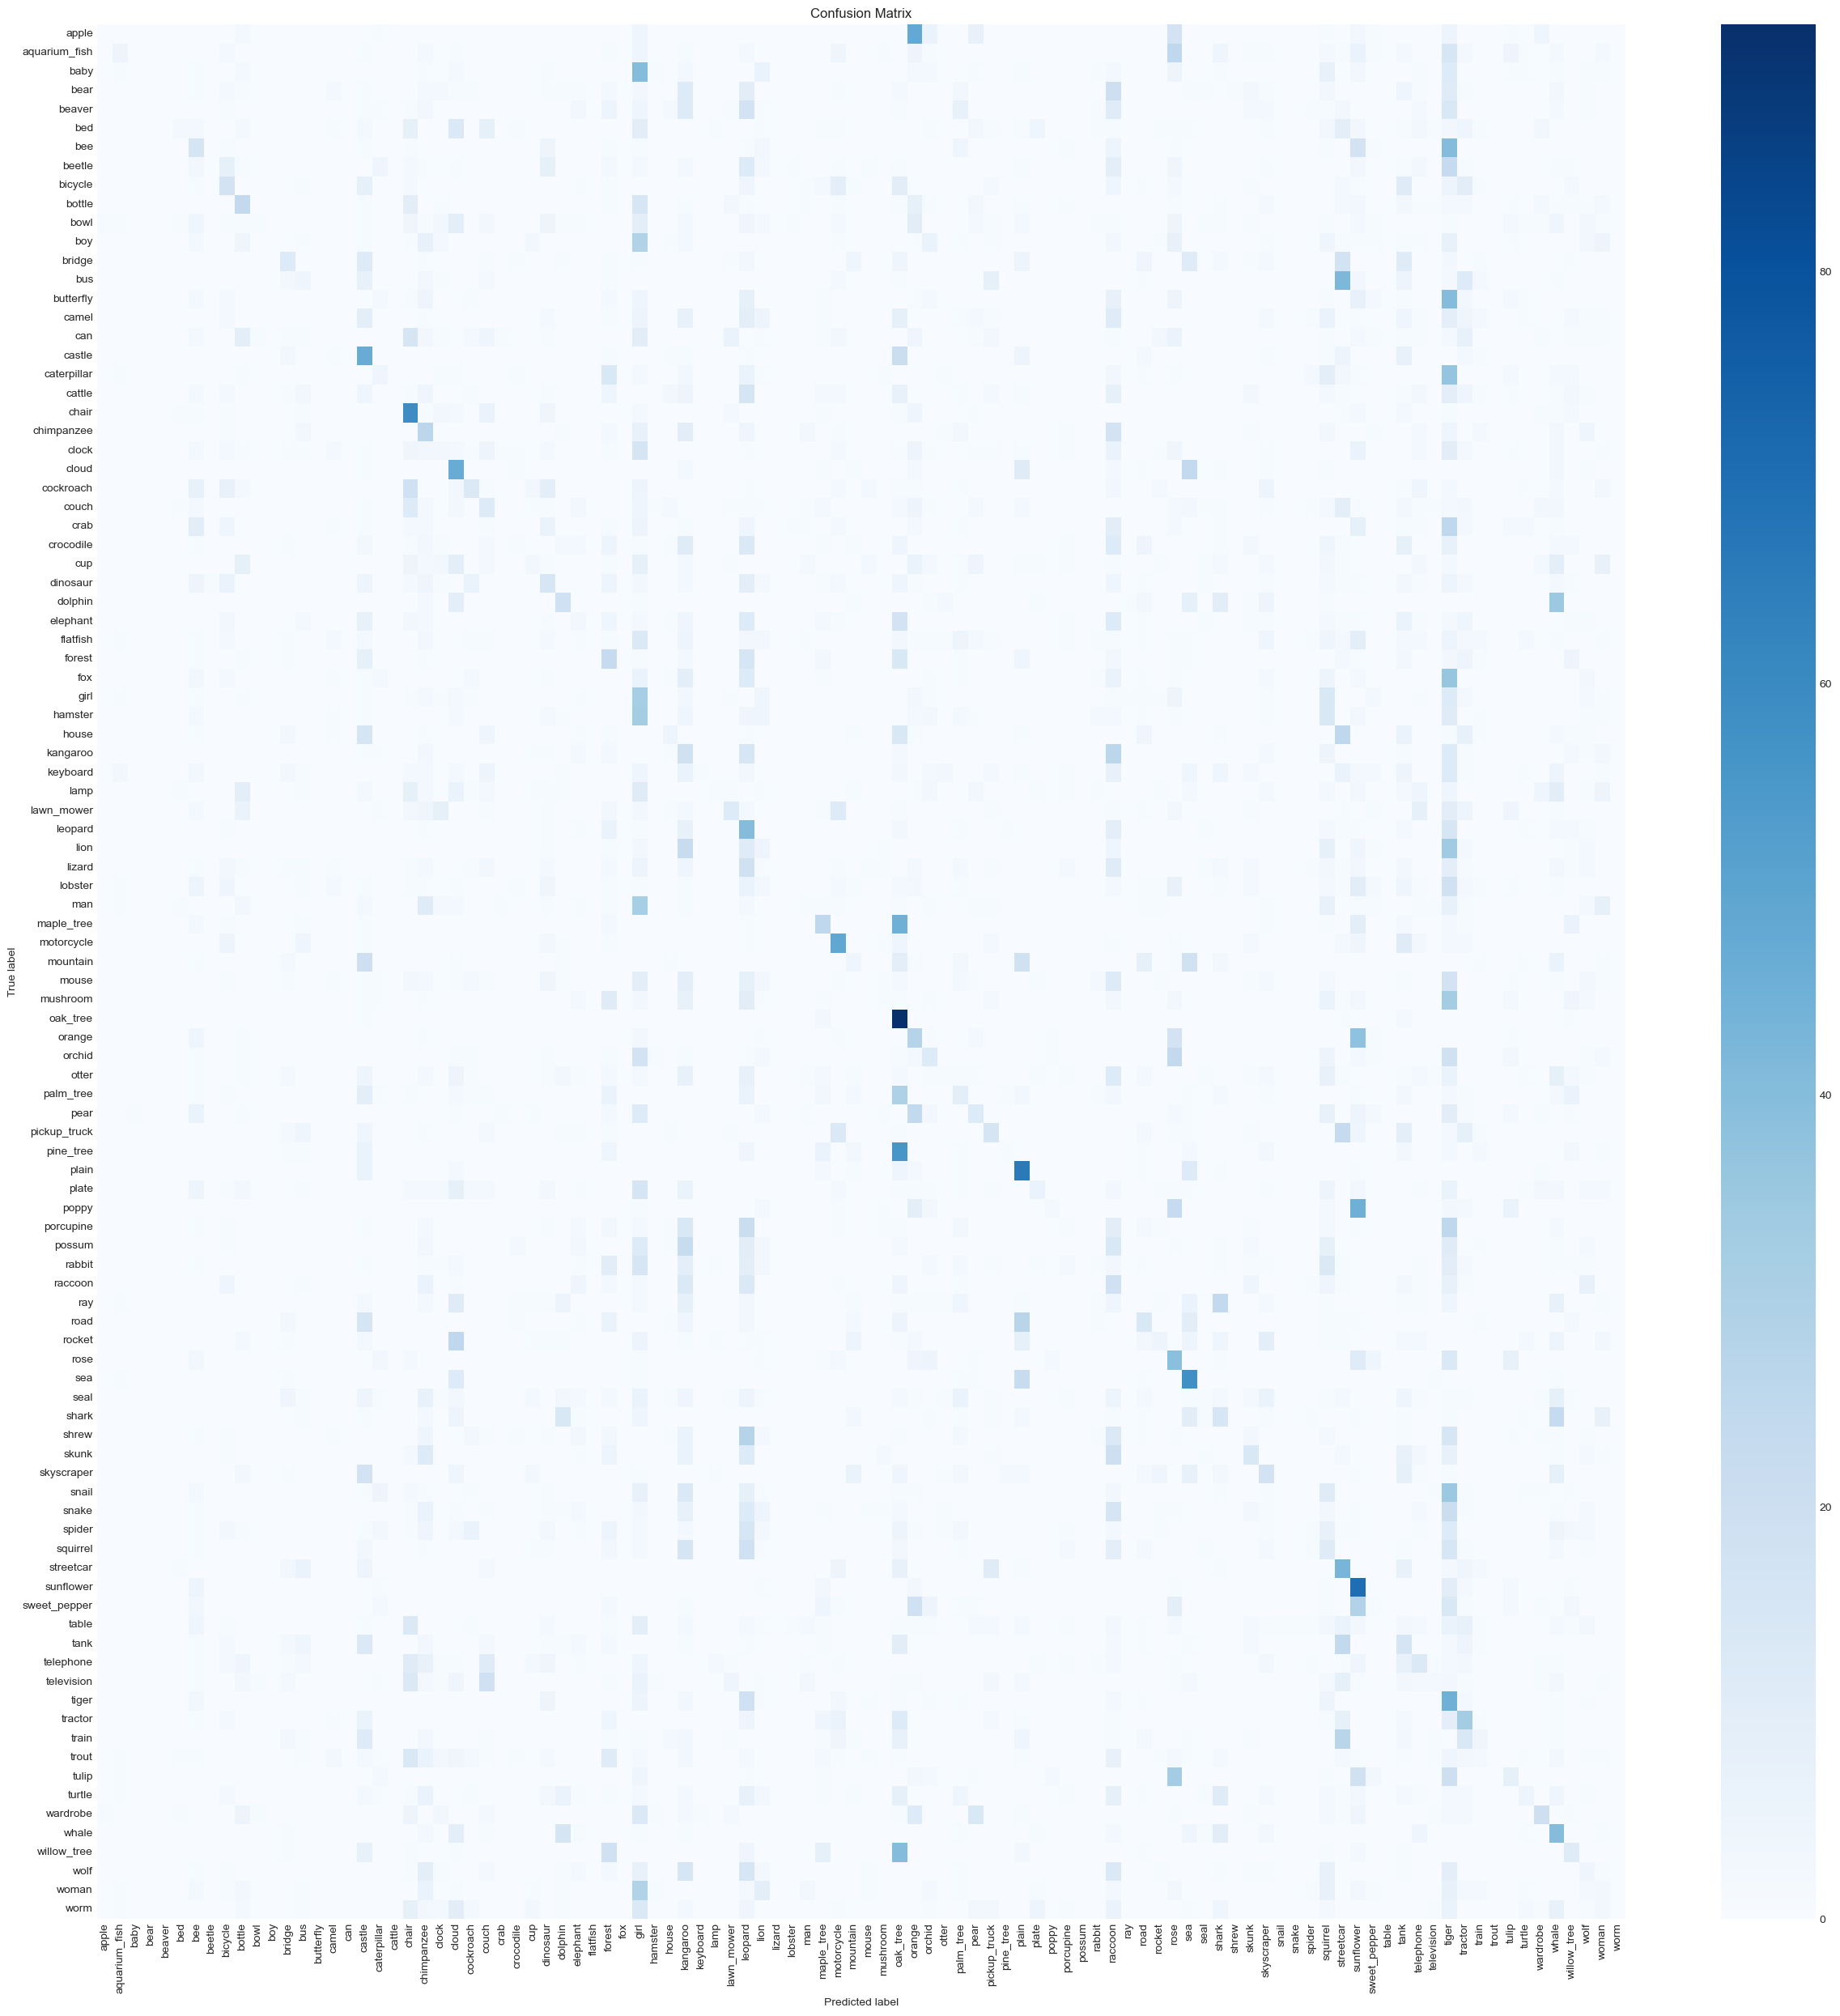


Searching for 25 misclassified images...


  0%|          | 0/79 [00:12<?, ?it/s]

Visualizing 25 misclassified images...
Misclassified images visualization saved to custom_cnn_misclassified_25.png


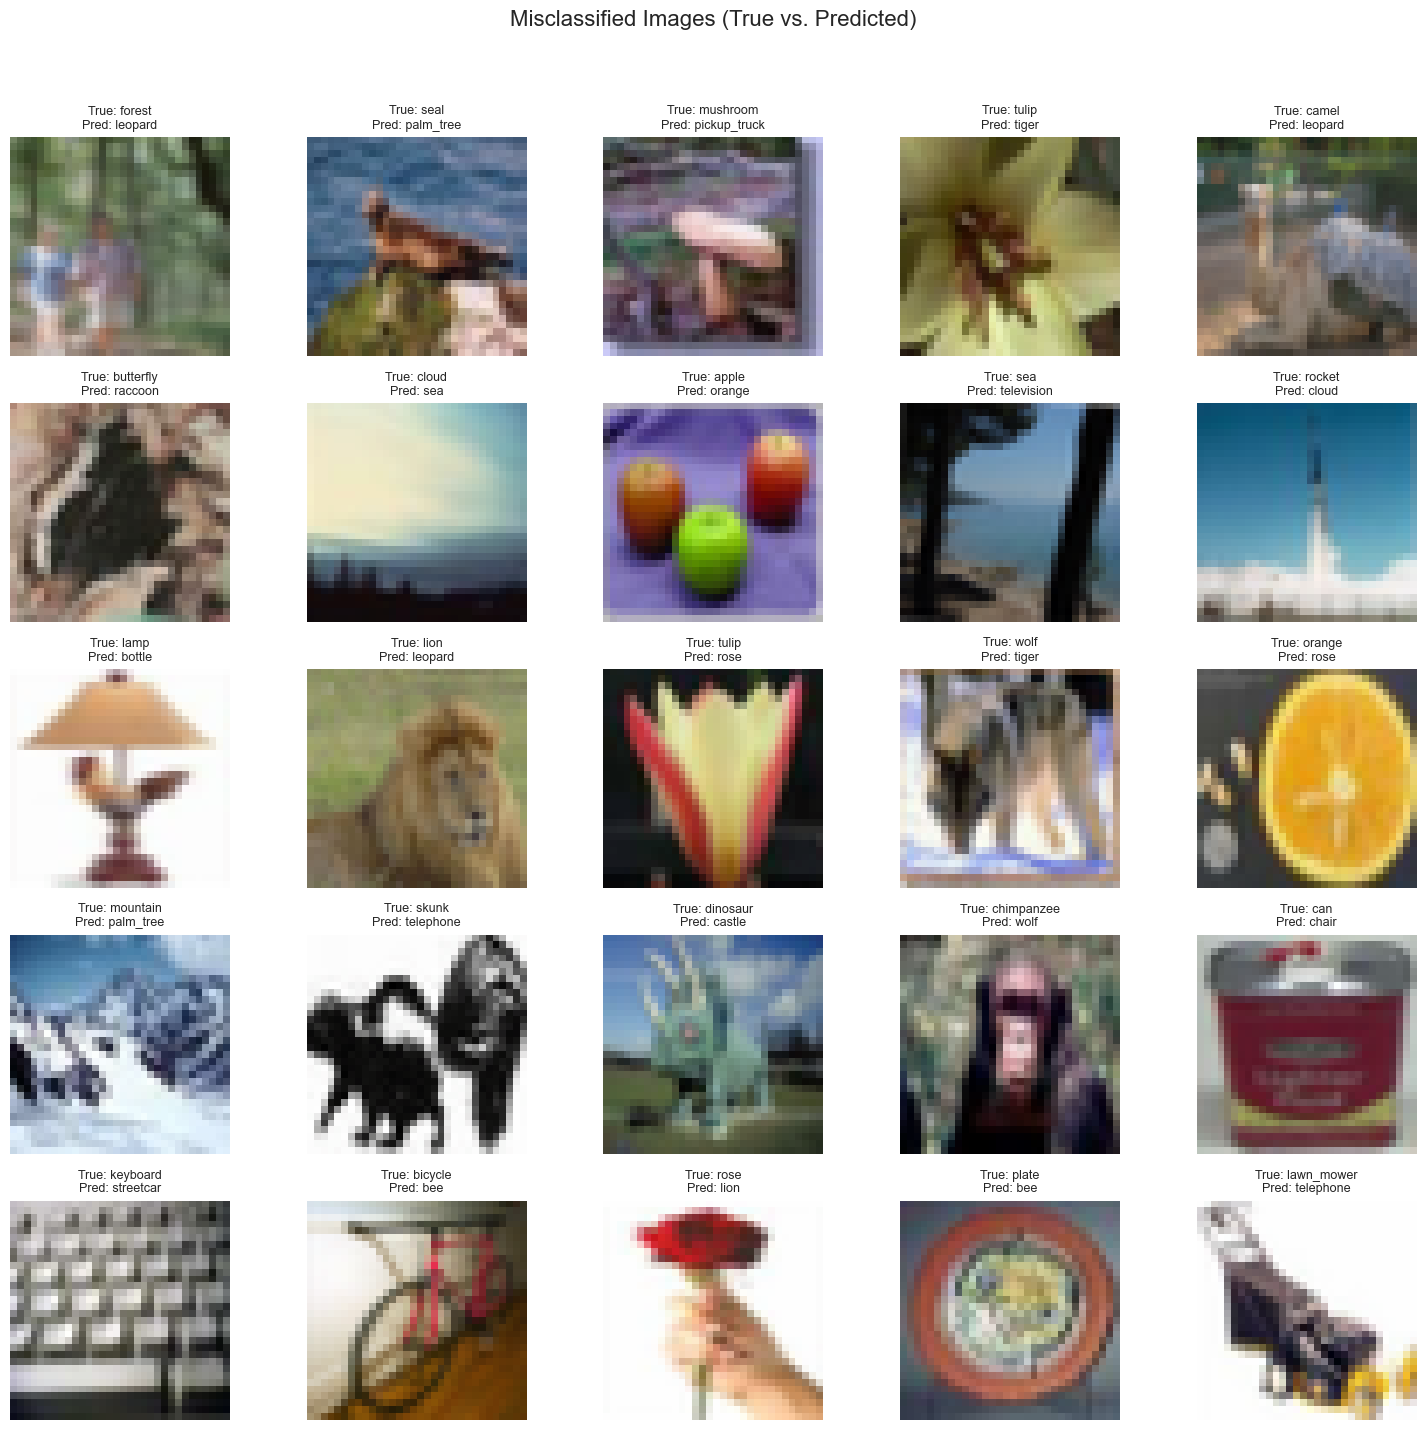

Accuracy history plot saved to custom_cnn_accuracy_history.png


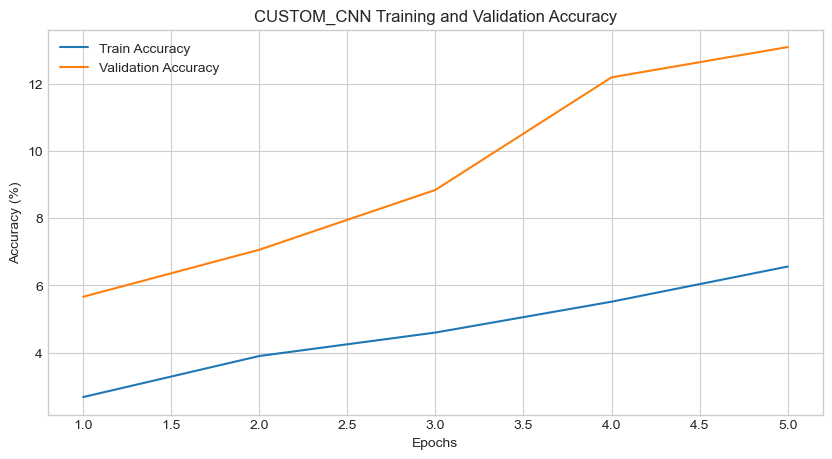

In [ ]:
NUM_EPOCHS = 50
BATCH_SIZE = 128
LEARNING_RATE = 0.001
IMG_SIZE = 32          # Keep 32 for Custom CNN
USE_AUGMENTATION = True
DATA_DIR = './data_cifar100'
NUM_WORKERS = 4
MODEL_NAME = "1_CustomCNN" # Model name for saving files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

# Get CIFAR-100 class names
class_names = get_cifar100_class_names(DATA_DIR)
num_classes = len(class_names)

print(f"Đang tải dữ liệu CIFAR-100 (Input size: {IMG_SIZE}x{IMG_SIZE})...")
train_loader, test_loader, _ = get_cifar100_loaders( # Use num_classes from class_names
    batch_size=BATCH_SIZE,
    data_dir=DATA_DIR,
    img_size=IMG_SIZE,
    use_augmentation=USE_AUGMENTATION,
    num_workers=NUM_WORKERS
)

if train_loader is None:
    print("Không thể tải dữ liệu. Kết thúc chương trình.")
    exit()

print("Khởi tạo Custom CNN model...")
# Pass the correct num_classes and input_size
model = CustomCNN(num_classes=num_classes, input_size=IMG_SIZE)

print("Bắt đầu huấn luyện Custom CNN...")
# Capture the returned model and histories
trained_model, train_history, test_history = train_model(
    model, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, device, model_name=MODEL_NAME
)

# --- Final Evaluation and Visualization ---
print("\n--- Performing Final Evaluation on Test Set ---")
final_metrics = evaluate_model(trained_model, test_loader, device, num_classes, class_names)

# Plot Confusion Matrix
if 'confusion_matrix' in final_metrics:
    plot_confusion_matrix(final_metrics['confusion_matrix'], class_names,
                            filename=f'{MODEL_NAME}_confusion_matrix.png',
                            figsize=(25, 25)) # Adjust size if needed

# Visualize Misclassified Images
visualize_misclassified(trained_model, test_loader, device, class_names,
                        num_images=25, # Number of images to show
                        filename_prefix=f'{MODEL_NAME}_misclassified')

# Plot Training/Validation Accuracy History
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_history, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), test_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title(f'{MODEL_NAME.upper()} Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(f'{MODEL_NAME}_accuracy_history.png')
print(f"Accuracy history plot saved to {MODEL_NAME}_accuracy_history.png")
plt.show() # Uncomment to display plots immediately